<a href="https://colab.research.google.com/github/mudesir/DS-Unit-2-Kaggle-Challenge/blob/master/Copy_of_LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [19]:
# print shape
print('Train shape: ', train.shape)
print('Val shape: ', val.shape)
print('Test shape: ', test.shape)

Train shape:  (47520, 46)
Val shape:  (11880, 46)
Test shape:  (14358, 45)


In [6]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [7]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [20]:
X_train.shape

(47520, 38)

In [33]:
# cross validation
# linear
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression, k=20),
    Ridge(alpha=1.0)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: unsupported operand type(s) for /: 'str' and 'int'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: unsupported operand type(s) for /: 'str' and 'int'

  FitFailedWarning)


MAE for 3 folds: [nan nan nan]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: unsupported operand type(s) for /: 'str' and 'int'

  FitFailedWarning)


In [ ]:
-scores.mean()

In [24]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: Could not convert functional needs repairfunctionalfunctional needs repairfunctionalfunctionalnon functionalfunctionalfunctionalnon functionalfunctionalfunctionalfunctionalfunctionalfunctionalfunctionalnon functionalfunctional needs repairfunctionalfunctionalfunctionalnon functionalfunctionalnon functionalfunctionalfunctionalfunctionalfunctional needs repairfunctionalfunctionalfunctionalnon functionalfunctionalfunctionalfunctionalfunctionalnon functionalnon functionalnon functionalnon functionalfunctionalnon functionalnon functionalnon functionalfunctionalnon functionalfunctional needs repairfunctionalfunctionalfunctionalfunctionalfunctionalfunctionalnon functionalnon functionalfunctional needs repairfunctionalfunctionalfunctionalfunctionalnon functionalfunctionalfu

MAE for 3 folds: [nan nan nan]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: Could not convert functionalfunctionalfunctionalnon functionalfunctionalfunctionalfunctionalfunctionalnon functionalnon functionalnon functionalnon functionalfunctionalfunctionalnon functionalfunctionalfunctionalnon functionalnon functionalfunctionalfunctionalfunctionalfunctionalfunctionalfunctionalfunctionalfunctionalfunctionalnon functionalnon functionalfunctionalfunctionalfunctionalfunctionalnon functionalfunctionalfunctional needs repairfunctionalfunctionalnon functionalnon functionalfunctionalfunctionalfunctionalfunctionalfunctional needs repairfunctionalnon functionalnon functionalfunctionalfunctionalfunctionalnon functionalfunctional needs repairfunctionalfunctionalnon functionalfunctionalfunctionalfunctionalfunctionalnon functionalfunctionalnon functionalfun

In [25]:
-scores.mean()

nan

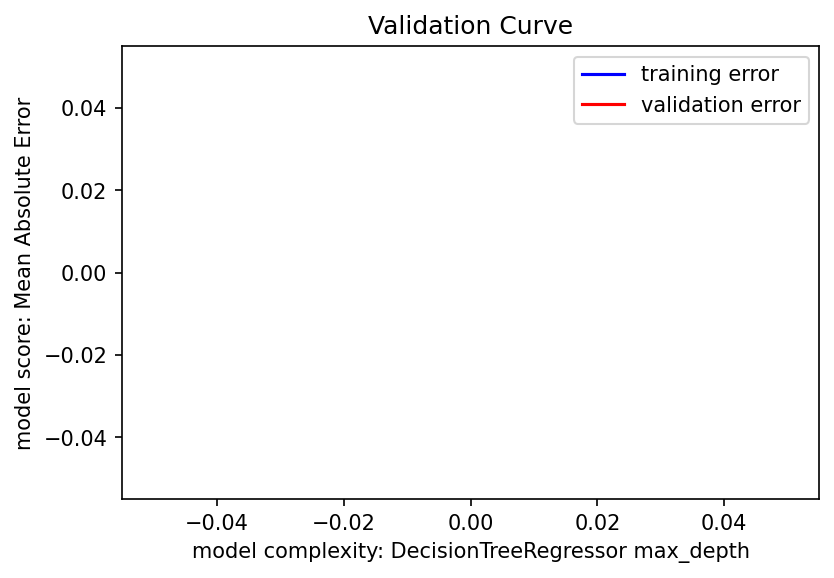

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeRegressor()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_absolute_error', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: DecisionTreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.legend();

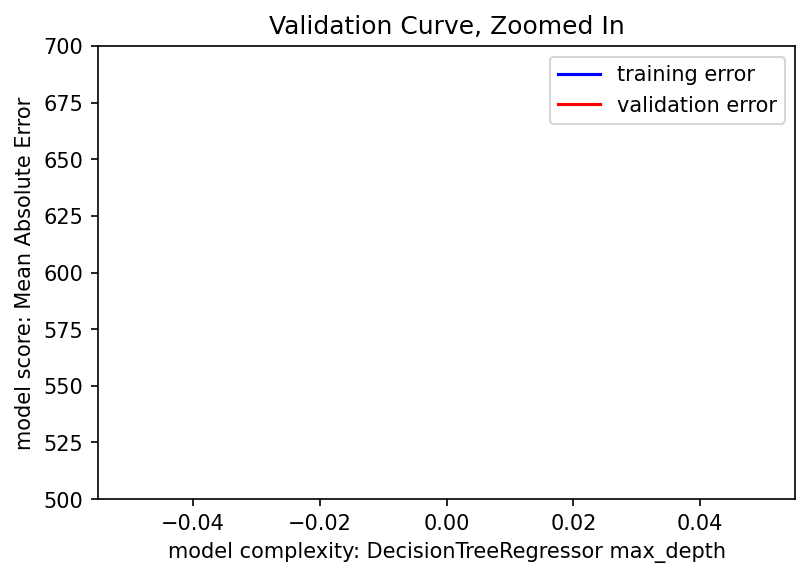

In [27]:
plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve, Zoomed In')
plt.xlabel('model complexity: DecisionTreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.ylim((500, 700))  # Zoom in
plt.legend();

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

features = train.columns.drop([target] + high_cardinality)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  8

TypeError: ignored

In [29]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'median', 'selectkbest__k': 35, 'ridge__alpha': 1}
Cross-validation MAE nan


In [ ]:
from scipy.stats import randint, uniform

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

In [31]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'median', 'selectkbest__k': 35, 'ridge__alpha': 1}
Cross-validation MAE nan


In [32]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

AttributeError: ignored

In [ ]:
pipeline = search.best_estimator_

In [ ]:
from sklearn.metrics import mean_absolute_error

X_test = test[features]
y_test = test[target]

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')